# Final project: Bankruptcy prediction

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import mglearn

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from sklearn.tree import export_graphviz
import graphviz
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a 

# The data

The problem you will solve is identical to that of the Midterm Project, but with expanded data.

As explained in the Final Project Overview:
- you will be given a data directory for training: `data/final_project/bankruptcy/train`

The data directory will contain one file per year.
- There are 5 years refered to as 1 through 5
- Files named: `1st_yr.csv,  2nd_yr.csv,  3rd_yr.csv,  4th_yr.csv,  5th_yr.csv`
- Let $i \in \{1, 2, 3, 4, 5 \}$.  The data in the file for year $-i$ contains
    - contains company characteristics for year $i$
    - the Bankruptcy field indicates whether the company is Bankrupt/Not Bankrupt in **year 6**
        - for year 1 (`1st.csv`), whether the company survives for 5 more years to **year 6**
        - for year 2 (`2nd.csv`), whether the company survives for 4 more years to **year 6**
        - and so forth

        
By comparison: for the Midterm project you were given data for year 5.
- the single file for the Midterm project indicated survival in the year ahead

You will need to 
- decide which files and which fields to use
- prepare the data for training and testing


In [2]:
DATA_PATH = "./data/final_project/bankruptcy/train"
TEST_PATH = "./data/final_project/bankruptcy/sample"

In [3]:
# all data files from each path stored in each dictionary
def data_reading(PATH):
    data_files = {}
    
    for file_name in os.listdir(PATH):
        print("Reading file: ", file_name)
        
        curr_table = pd.read_csv(os.path.join(PATH, file_name), index_col=['Id'], low_memory=False)
        curr_table.replace('?', np.nan, inplace = True)
        curr_table.iloc[:, :-1] = curr_table.iloc[:, :-1].astype(np.float64)
        
        # fill missing value with median
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
        curr_table.loc[:, curr_table.columns!='Bankrupt'] = imp_mean.fit_transform(curr_table.loc[:, curr_table.columns!='Bankrupt'])
        
        # save
        data_files[file_name[:-4]] = curr_table
    
    print("Finished Reading for Folder: ", PATH)
    return data_files

In [4]:
train_files = data_reading(DATA_PATH)
test_files = data_reading(TEST_PATH)

Reading file:  1st_yr.csv
Reading file:  2nd_yr.csv
Reading file:  3rd_yr.csv
Reading file:  4th_yr.csv
Reading file:  5th_yr.csv
Finished Reading for Folder:  ./data/final_project/bankruptcy/train
Reading file:  1st_yr.csv
Reading file:  2nd_yr.csv
Reading file:  3rd_yr.csv
Reading file:  4th_yr.csv
Reading file:  5th_yr.csv
Finished Reading for Folder:  ./data/final_project/bankruptcy/sample


## Exploratory Data Analysis

### Attribute Information:
  
Id Company Identifier  
X1 net profit / total assets  
X2 total liabilities / total assets  
X3 working capital / total assets  
X4 current assets / short-term liabilities  
X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365  
X6 retained earnings / total assets  
X7 EBIT / total assets  
X8 book value of equity / total liabilities  
X9 sales / total assets  
X10 equity / total assets  
X11 (gross profit + extraordinary items + financial expenses) / total assets  
X12 gross profit / short-term liabilities  
X13 (gross profit + depreciation) / sales  
X14 (gross profit + interest) / total assets  
X15 (total liabilities * 365) / (gross profit + depreciation)  
X16 (gross profit + depreciation) / total liabilities  
X17 total assets / total liabilities  
X18 gross profit / total assets  
X19 gross profit / sales  
X20 (inventory * 365) / sales  
X21 sales (n) / sales (n-1)  
X22 profit on operating activities / total assets  
X23 net profit / sales  
X24 gross profit (in 3 years) / total assets  
X25 (equity - share capital) / total assets  
X26 (net profit + depreciation) / total liabilities  
X27 profit on operating activities / financial expenses  
X28 working capital / fixed assets  
X29 logarithm of total assets  
X30 (total liabilities - cash) / sales  
X31 (gross profit + interest) / sales  
X32 (current liabilities * 365) / cost of products sold  
X33 operating expenses / short-term liabilities  
X34 operating expenses / total liabilities  
X35 profit on sales / total assets  
X36 total sales / total assets  
X37 (current assets - inventories) / long-term liabilities  
X38 constant capital / total assets  
X39 profit on sales / sales  
X40 (current assets - inventory - receivables) / short-term liabilities  
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))  
X42 profit on operating activities / sales  
X43 rotation receivables + inventory turnover in days  
X44 (receivables * 365) / sales  
X45 net profit / inventory  
X46 (current assets - inventory) / short-term liabilities  
X47 (inventory * 365) / cost of products sold  
X48 EBITDA (profit on operating activities - depreciation) / total assets  
X49 EBITDA (profit on operating activities - depreciation) / sales  
X50 current assets / total liabilities  
X51 short-term liabilities / total assets  
X52 (short-term liabilities * 365) / cost of products sold)  
X53 equity / fixed assets  
X54 constant capital / fixed assets  
X55 working capital  
X56 (sales - cost of products sold) / sales  
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)  
X58 total costs /total sales  
X59 long-term liabilities / equity  
X60 sales / inventory  
X61 sales / receivables  
X62 (short-term liabilities *365) / sales  
X63 sales / short-term liabilities  
X64 sales / fixed assets  


In [5]:
train_files['1st_yr'].describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,5744.000000,5744.000000,5744.000000,5744.000000,5.744000e+03,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,...,5.744000e+03,5744.000000,5.744000e+03,5744.000000,5.744000e+03,5744.000000,5.744000e+03,5744.000000,5744.000000,5744.000000
mean,0.019249,0.572996,0.104619,2.649544,-1.901397e+02,0.056435,0.333718,2.657701,5.709752,1.925513,...,-1.928692e+02,0.245292,1.938742e+02,0.234913,4.998401e+02,16.823723,4.539629e+03,8.238839,229.910772,0.035515
std,5.047982,5.914677,5.832130,14.163582,4.011208e+04,6.690639,9.100296,20.283874,101.076954,34.562625,...,1.462346e+04,2.379982,1.462345e+04,6.924780,2.861504e+04,288.767419,3.300802e+05,20.636441,5564.368199,0.185094
min,-256.890000,-72.162000,-440.500000,0.000000,-2.722100e+06,-397.890000,-189.560000,-141.410000,0.000005,-440.550000,...,-1.108300e+06,-47.491000,-1.436000e-03,-327.970000,4.700000e-05,0.000016,0.000000e+00,0.000015,0.000010,0.000000
25%,0.020799,0.298790,0.027175,1.065950,-4.430525e+01,0.000000,0.026850,0.451745,1.037275,0.302478,...,1.961300e-02,0.055896,8.647975e-01,0.000000,6.016375e+00,4.829375,4.327875e+01,3.410525,2.525650,0.000000
50%,0.076136,0.481790,0.181155,1.501750,-5.309400e+00,0.000000,0.090299,1.021400,1.207000,0.495330,...,6.286150e-02,0.176390,9.394150e-01,0.030083,1.002300e+01,7.010400,6.841500e+01,5.313050,4.643200,0.000000
75%,0.160530,0.676865,0.360538,2.431425,3.799475e+01,0.145385,0.189370,2.233400,2.136325,0.673508,...,1.375500e-01,0.352950,9.822225e-01,0.271297,1.969125e+01,10.660000,1.070250e+02,8.310750,9.802950,0.000000
max,94.280000,441.500000,1.000000,1017.800000,9.909000e+05,303.670000,453.770000,1452.200000,3876.100000,1099.500000,...,1.000000e+00,126.670000,1.108300e+06,119.580000,2.137800e+06,21110.000000,2.501600e+07,1042.200000,294770.000000,1.000000


In [6]:
train_describe_std = train_files['1st_yr'].describe().loc['std',:]
extreme_cols = train_describe_std[train_describe_std>10000].index.values
regular_cols = [col for col in train_files['1st_yr'].columns[:-1] if col not in extreme_cols]

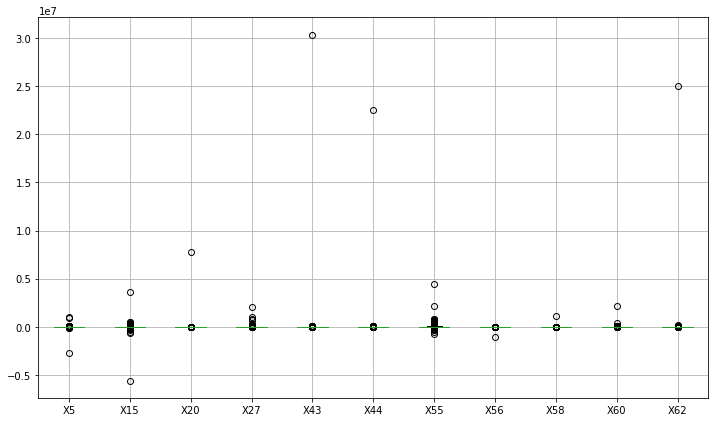

In [7]:
train_files['1st_yr'].loc[:,extreme_cols].boxplot()

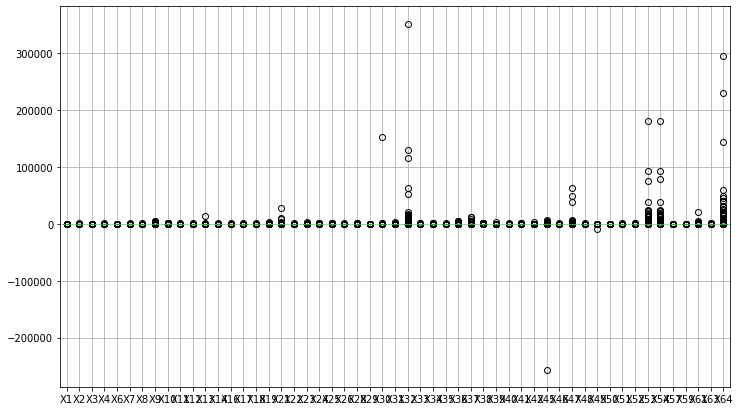

In [8]:
train_files['1st_yr'].loc[:, regular_cols].boxplot()

We can see from above boxplots that variables are mostly normally distributed but some variables have large standard deviations and ranges, such as X43, X62, etc. We would like to eliminate outliers (companies) that have extreme values on these variables.

(array([5540.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         204.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

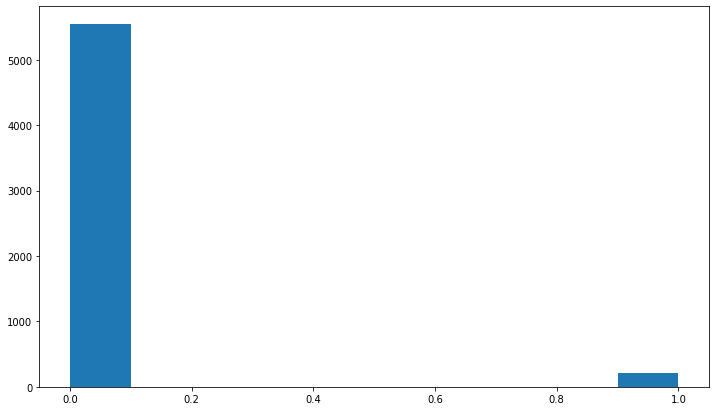

In [9]:
plt.hist(train_files['1st_yr'].iloc[:,-1])

### Issue 1: classes being imbalanced
### Issue 2: different importance of each type of missclassification
* solution 1: change performance metric -> recall score
* solution 2: use decision tree because it performs well under imbalanced data
* solution 3: generate synthetic samples to oversample minority class or undersample majority class
  
We can see from the above histogram that our data is imbalanced for 0 and 1. To avoid this problem, we proposed 3 solutions. Since it is worse to misclassify a company that does go bankrupt, and 1 - recall score (TP/FN) measures it, so we want recall score as large as possible. Therefore, we use recall score as scoring method.  
Therefore, we try gradient boosting model, use recall score to compare models, and oversample minority class.

In [10]:
train_data = pd.concat(train_files, axis=1, join='inner')

In [11]:
train_data.loc[:, (slice(None), 'Bankrupt')].head()

,1st_yr,2nd_yr,3rd_yr,4th_yr,5th_yr
,Bankrupt,Bankrupt,Bankrupt,Bankrupt,Bankrupt
Id,,,,,
3735,0,0,0,0,0
4564,1,0,0,0,0
5877,0,0,0,1,0
2507,0,0,0,0,0
3901,0,0,0,0,0


## Data processing
From EDA, we want to drop outliers that are outside of 3 standard deviations first, then upsample minority (1) using synthetic samples.

In [12]:
def drop_numerical_outliers(df, z_thresh=3):
    print('Before dropping outliers: ', df.shape)
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.iloc[:,:-1].select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
    print('After dropping outliers: ', df.shape)

In [13]:
"""
Need to split train test sets before upsampling
We only upsample train set
"""
def upsampling_minority(X, y):
    # setting up testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
    
    print('Before upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Unbalanced training data{}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))
    
    sm = SMOTE(random_state=10)
    X_train, y_train = sm.fit_resample(X_train, y_train)
   
    print('Finished upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Balanced training data {}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))
    
    return X_train, X_test, y_train, y_test

# Modeling


## Grid Search

In [14]:
"""
Plot test score heatmap of parameter sets
"""
def plot_heatmap(grid, params):
    results = pd.DataFrame(grid.cv_results_)
    keys = list(params.keys())
    scores = np.array(results.mean_test_score).reshape(len(params[keys[1]]), 
                                                             len(params[keys[0]]))
    plt.figure()
    mglearn.tools.heatmap(scores, xlabel=keys[0], xticklabels=params[keys[0]], 
                          ylabel=keys[1], yticklabels=params[keys[1]], 
                          cmap="viridis", fmt='%0.5f')
    plt.show()

### Parameter Tunning for GBM
1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
2. Determine the optimum number of trees 'n_estimators' for this learning rate.
3. Tune tree-specific parameters for decided learning rate and number of trees:
    1. min_samples_split: This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
    2. min_samples_leaf: Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
    3. max_depth: based on the number of observations and predictors.
    4. max_features
    5. subsample: proportion of samples used in tunning a tree
4. Lower the learning rate and increase the estimators proportionally to get more robust models.

In [15]:
"""
Grid search for gradient boosting model
"""
def gbm_grid_search(original_gbm, X_train, y_train, score_method, show_plots, predictors):
    
    # tune n_estimators, max_depth
    param_trees = {'n_estimators': [i for i in range(10, 101, 30)],
                  'max_depth': [i for i in range(2,6,1)]}
    gsearch1 = GridSearchCV(estimator = original_gbm, 
                            param_grid = param_trees, 
                            scoring=score_method,
                            n_jobs=-1,
                            iid=False,
                            cv=5
                           )
    gsearch1.fit(X_train, y_train)
    if show_plots:
        print('Best parameters: ', gsearch1.best_params_)
        plot_heatmap(gsearch1, param_trees)
    
    # tune min_samples_split, min_samples_leaf
    param_tree2 = {'min_samples_split': [i for i in range(10,51,20)],
                  'min_samples_leaf': [i for i in range(10,51,20)]}
    gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, 
                            param_grid = param_tree2, 
                            scoring=score_method,
                            n_jobs=-1,
                            iid=False, 
                            cv=5)
    gsearch2.fit(X_train, y_train)
    if show_plots:
        print('Best parameters: ', gsearch2.best_params_)
        plot_heatmap(gsearch2, param_tree2)
    
    # tune learning_rate
    n_estimator = gsearch1.best_params_['n_estimators']
    param_tree3 = [{'learning_rate': [0.1],
                  'n_estimators': [n_estimator]},
                  {'learning_rate': [0.1*5],
                  'n_estimators': [n_estimator//5]},
                  {'learning_rate': [0.1/10],
                  'n_estimators': [n_estimator*10]}]
    gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_, 
                            param_grid = param_tree3, 
                            scoring=score_method,
                            n_jobs=-1,
                            iid=False, 
                            cv=5)
    gsearch3.fit(X_train, y_train)
    print('Best score: ', gsearch3.best_score_)                 
    
    # best estimator
    gbm1 = gsearch3.best_estimator_
    
    # plot result tree and feature importance
    if show_plots:
        print('Best parameters: ', gsearch3.best_params_)
        print('Show Tree:\n')
        export_graphviz(gbm1.estimators_[0][0])
        with open("tree.dot") as f:
            dot_graph = f.read()
        display(graphviz.Source(dot_graph))
        
        print('Show Feature Importance:\n')
        feat_imp = pd.Series(data=gbm1.feature_importances_, index=predictors).sort_values(ascending=False)
        plt.figure()
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
    
    return gbm1

### Parameter Tunning for Neural Network
input: (feature,) = (64,)  
output: one number 0/1

#### Speed up techniques
1. Normalize input (X)  
2. Initialize weight, uses activation 'relu'  
3. Using mini-batch gradient descent: 32, 64, 128...  
4. Using 'adam' optimizer  

#### Hyperparameters
* batch size: 64, 128    
* hidden units/layers: 3 layers, [64, 16, 1] (default) seems reasonable with a starting 41 features, [32, 16, 1] for comparison    
* epoch: 5, 10
* loss: binary crossentropy, to classify bankrupt / not bankrupt
* polynomial features: degree 1, 2

#### Process
1. feature engineering: try polynomial features of degree 1 or 2
2. normalize features
3. train model using grid search cross validation
  

In [16]:
def nn_3layers(n_hiddens=[64,16], input_size=64):
    nn_model = Sequential([ layers.Dense(n_hiddens[0], activation=tf.nn.relu, name="hidden1", input_shape=(input_size,)),
                               layers.Dense(n_hiddens[1], activation=tf.nn.relu, name='hidden2'),
                               layers.Dense(1, activation=tf.nn.sigmoid, name="outputs")
                             ]
                            )
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return nn_model

In [17]:
def nn_grid_search(X_train, y_train, score_method, nn_layers=nn_3layers):
    nn_model = KerasClassifier(build_fn=nn_layers)
    pipe_nn = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), nn_model)
    param_nn = [{'polynomialfeatures__degree': [1],
                'kerasclassifier__input_size': [len(PolynomialFeatures(1, include_bias=False).fit(X_train).get_feature_names())],
                'kerasclassifier__n_hiddens': [[64, 16], [32, 16]],
                'kerasclassifier__epochs': [5,10],
                'kerasclassifier__batch_size': [64, 128]
               },
                {'polynomialfeatures__degree': [2],
                'kerasclassifier__input_size': [len(PolynomialFeatures(2, include_bias=False).fit(X_train).get_feature_names())],
                'kerasclassifier__n_hiddens': [[64, 16], [32, 16]],
                'kerasclassifier__epochs': [5,10],
                'kerasclassifier__batch_size': [64, 128]
               }]
    nsearch = GridSearchCV(estimator=pipe_nn, 
                        param_grid=param_nn,
                        scoring=score_method,
                        n_jobs=-1, 
                        iid=False,
                        cv=3)

    nsearch.fit(X_train, y_train)
    print('Best parameters: ', nsearch.best_params_)
    
    return nsearch.best_estimator_

## Main Function
It incorporates data processing, sampling, and model training and outputs all trained models:
* Naive Bayes
* Logistic Regression
* Support Vector Machine
* Gradient Boosting Tree
* Neural Network

In [18]:
def MyModel(X_train, y_train, show_plots=True, score_method='recall'):
    
    """
    Naive Bayes
    """
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    print('Finished training Naive Bayes...')
    
    """
    Logistic Regression
    """
    params_logit = {'polynomialfeatures__degree': [1, 2],
               'selectpercentile__percentile': [50, 100],
               'logisticregression__C': [0.01, 1, 100]}
    pipe_logit = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(), SelectPercentile(), 
                               LogisticRegression(max_iter=1000))
    lsearch = GridSearchCV(estimator=pipe_logit, 
                           scoring='recall', 
                           param_grid=params_logit, 
                           cv=5, 
                           iid=False, 
                           n_jobs=-1)
    lsearch.fit(X_train, y_train)
    lr = lsearch.best_estimator_
    print('Finished training Logistic Regression...')
    
    """
    Support Vector Machine
    """
    params_svc = [{'svc__kernel' : ['rbf'],
             'svc__gamma' : [0.01, 0.1, 1, 10, 100],
             'svc__C' : [0.01, 0.1, 1, 10, 100]},
             {'svc__kernel' : ['linear'],
             'svc__C' : [0.01, 0.1, 1, 10, 100]}]
    pipe_svc = make_pipeline(MinMaxScaler(), SVC()) # no need for polynomialfeatures
    ssearch = GridSearchCV(estimator=pipe_svc, 
                           scoring='recall', 
                           param_grid=params_svc, 
                           cv=5, 
                           iid=False, 
                           n_jobs=-1)
    ssearch.fit(X_train, y_train)
    svc = ssearch.best_estimator_
    print('Finished training Support Vector Machine...')
    
    """
    GBM
    """
    gbm0 = GradientBoostingClassifier(random_state=10)
    gbm0.fit(X_train, y_train)
    gbm1 = gbm_grid_search(gbm0, X_train, y_train, 
                           score_method=score_method, show_plots=show_plots, predictors = X.columns)
    print('Finished training Gradient Boosting...')
    
    """
    NN
    """
    nn = nn_grid_search(X_train, y_train, score_method='recall')
    print('Finished training Neural Network...')
    
    # all models
    models = [clf, lr, svc, gbm1, nn]
    
    return models

In [19]:
data = train_files['1st_yr'].copy()  # can also try data for other years

In [20]:
"""
Sampling
"""
drop_numerical_outliers(data)
y = data.loc[:,'Bankrupt']
X = data.loc[:, data.columns!='Bankrupt']
X_train, X_test, y_train, y_test = upsampling_minority(X, y)

Before dropping outliers:  (5744, 65)
After dropping outliers:  (5454, 65)
Before upsampling: training data shape (4090, 64) test data shape (1364, 64)
Unbalanced training data{'Not Bankrupt': 3950, 'Bankrupt': 140}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions
  """


Finished upsampling: training data shape (7900, 64) test data shape (1364, 64)
Balanced training data {'Not Bankrupt': 3950, 'Bankrupt': 3950}


Finished training Naive Bayes...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Finished training Logistic Regression...
Finished training Support Vector Machine...
Best parameters:  {'max_depth': 5, 'n_estimators': 100}


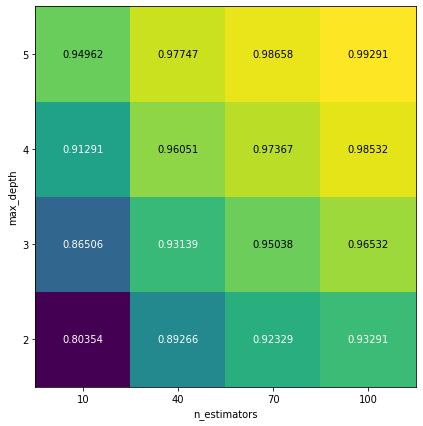

Best parameters:  {'min_samples_leaf': 10, 'min_samples_split': 30}


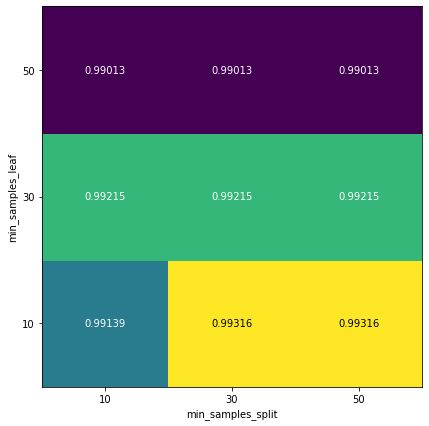

Best score:  0.9931645569620253
Best parameters:  {'learning_rate': 0.1, 'n_estimators': 100}
Show Tree:



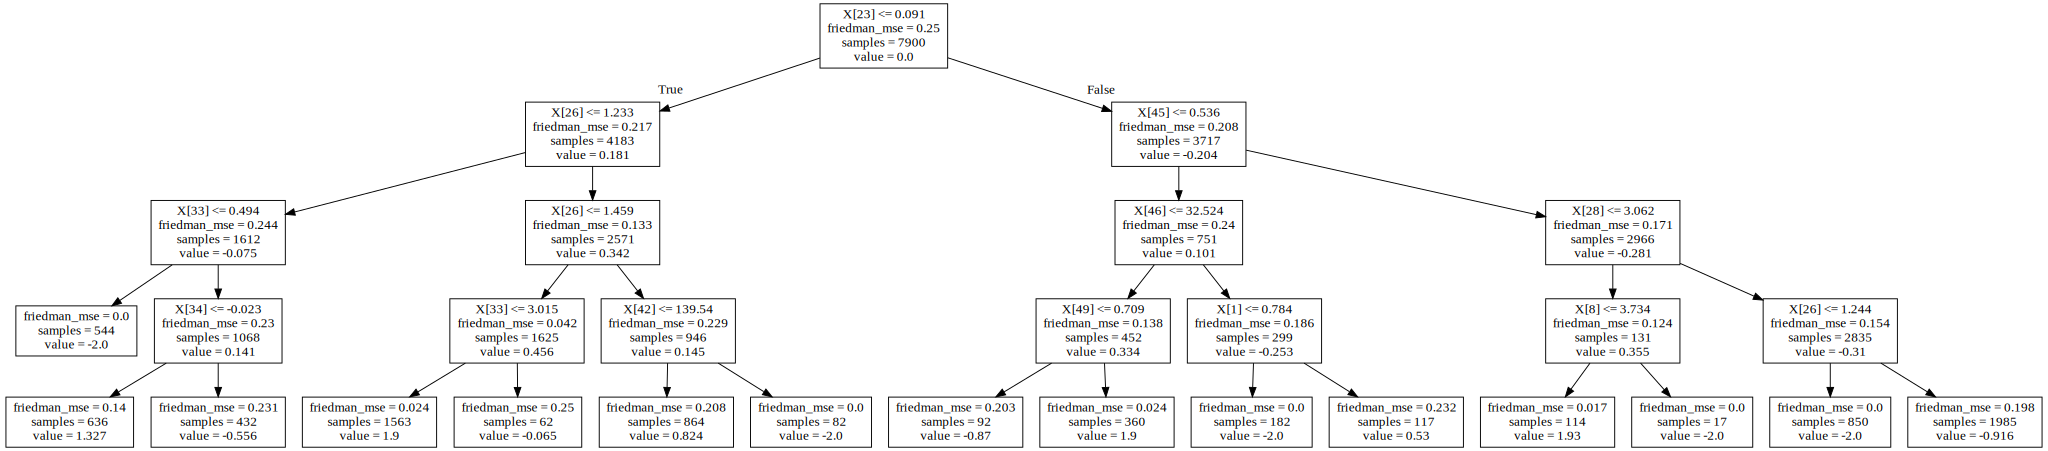

Show Feature Importance:



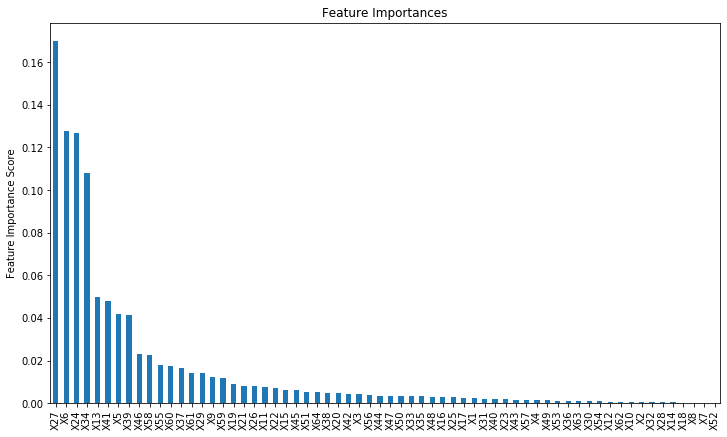

Finished training Gradient Boosting...
Epoch 1/10
7900/7900 [==============================] - 1s 109us/step - loss: 0.4578 - acc: 0.7938
Epoch 2/10
7900/7900 [==============================] - 1s 66us/step - loss: 0.2313 - acc: 0.9166
Epoch 3/10
7900/7900 [==============================] - 0s 55us/step - loss: 0.1504 - acc: 0.9485
Epoch 4/10
7900/7900 [==============================] - 0s 49us/step - loss: 0.1153 - acc: 0.9610
Epoch 5/10
7900/7900 [==============================] - 0s 49us/step - loss: 0.0939 - acc: 0.9701
Epoch 6/10
7900/7900 [==============================] - 0s 46us/step - loss: 0.0738 - acc: 0.9754
Epoch 7/10
7900/7900 [==============================] - 0s 50us/step - loss: 0.0599 - acc: 0.9800
Epoch 8/10
7900/7900 [==============================] - 0s 47us/step - loss: 0.0509 - acc: 0.9848
Epoch 9/10
7900/7900 [==============================] - 0s 50us/step - loss: 0.0409 - acc: 0.9889
Epoch 10/10
7900/7900 [==============================] - 0s 46us/step - loss: 

In [21]:
mymodels = MyModel(X_train, y_train)

# Performance Analysis
Compare performance of all models, metrics used:
* accuracy
* precision
* recall
* f1
* roc_auc

In [22]:
"""
Comparison of models
"""
def CompareModels(models, curve, show_plots=True, X_test=X_test, y_test=y_test):
    final_report = pd.DataFrame(index=['clf', 'lr', 'svc', 'gbm', 'nn'], 
                            columns=['accuracy', 'precision', 'recall', 'f1',  'f1_macro'])
    
    for i in range(len(models)):
        model = models[i]
        name = final_report.index[i]
        report = pd.DataFrame(classification_report(y_test, model.predict(X_test), output_dict=True)).transpose()
        final_report.loc[name, :] = [report.loc['accuracy', 'support'], 
                                 report.loc['1', 'precision'],
                                 report.loc['1', 'recall'],
                                 report.loc['1', 'f1-score'],
                                 report.loc['macro avg', 'f1-score']]
        
    print("Model Comparison Report:\n", final_report)
    
    
    def plot_curve(model, model_name, marker, decision_function, curve):
        if decision_function:
            precision, recall, thresholds = curve(y_test, model.decision_function(X_test))
            close = np.argmin(np.abs(thresholds))
        else:
            precision, recall, thresholds = curve(y_test, model.predict_proba(X_test)[:,1])
            close = np.argmin(np.abs(thresholds - 0.5))

        plt.plot(precision, recall, label=model_name)
        plt.plot(precision[close], recall[close], marker, c='k', markersize=10, 
                label="threshold "+model_name, fillstyle='none', mew=2)
        
    # roc_auc plot
    if show_plots:
        plt.figure()
        plt.title('Curve')
        plot_curve(models[1], 'lr', 'o', False, curve)
        plot_curve(models[2], 'svc', '^', True, curve)
        plot_curve(models[3], 'gbm', 'D', False, curve)
        plot_curve(models[4], 'nn', '*', False, curve)
        plt.legend()
        plt.show()
    

Model Comparison Report:
      accuracy  precision    recall         f1  f1_macro
clf   0.21261  0.0454951  0.927273  0.0867347  0.197362
lr   0.920821   0.208791  0.345455   0.260274  0.609223
svc  0.919355   0.151899  0.218182   0.179104  0.568349
gbm  0.961877   0.523077  0.618182   0.566667  0.773364
nn   0.935484   0.273973  0.363636     0.3125  0.639327


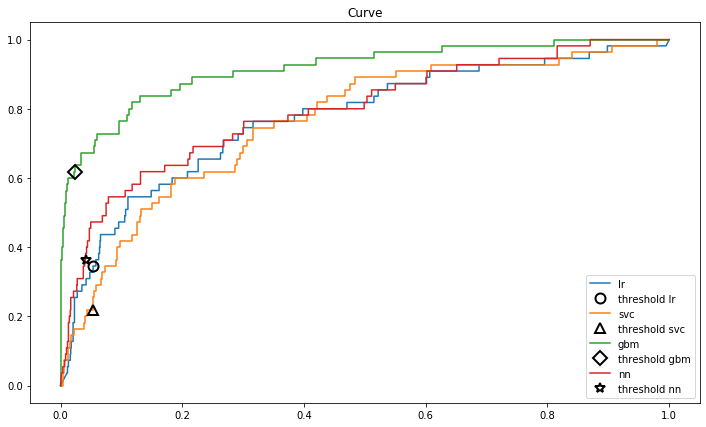

In [23]:
CompareModels(mymodels, roc_curve)

# Out of sample evaluation

*You*  should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

It is up to you to decide on the out of sample data that you use for model development.



**The training data directory is highly imbalanced**
- You should expect the holdout data directory to be more balanced
- So you should strive to predict well on the minority class

In [24]:
input_test = test_files['1st_yr'].copy()  # can also try for other years
best_model = mymodels[-2]

In [25]:
best_predictions = best_model.predict(input_test)
best_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [26]:
nn_predictions = mymodels[-1].predict(input_test).reshape(1,-1)[0]
nn_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
print('GBM and NN produce', (best_predictions==nn_predictions).sum() / len(best_predictions), 'of same results')

GBM and NN produce 0.9651567944250871 of same results


# Conclusion

By comparing performance metrics, we can see that Gradient Boosting model has the highest accuracy, precision, f1 scores, best roc_auc curve and a high recall rate of 0.62 (the metric we value the most), becoming the best model for predicting bankruptcy. Logistic Regression and Neural Network perform secondly as well. It proves that trees work best with imbalanced data.  
  
From heatmap we can see that the model is improved using grid search on several parameters. According to feature importance, X27, X6, X24, X34 are the most important variables in explaining bankruptcy.  
  
For demonstration purpose, we only show training and prediction using 1st year data to predict bankruptcy of companies in year 6. We could also change our input data to 2nd_yr...5th_yr, which are not shown. But the results would be the same that GBM remain the best model overall.

# Suggestion

- Training, test, and holdout directories should all be similar
- It might be best for  you to write a single procedure that takes a directory name and prepares the data
    - If you use the same procedure for training, test, and holdout you are less likely to make mistakes.

# Submission

You will submit a *single* model for evaluation.

We will run this model on the holdout data directory (which we don't provide)
- the holdout data directory will be very similar to training but without targets
- your model should produce a prediction for each example in the holdout directory
- you can test your submission on the following dummy holdout directory: 
    - `data/final_project/bankruptcy/sample`
    

In [32]:
from tensorflow.python.keras.models import load_model
from sklearn.externals import joblib

modelName = "final_model"
model_path = os.path.join(modelName + ".h5")   

def saveModel(pipeline, model_path):
    # Save the Keras model first:
    pipeline.named_steps['kerasclassifier'].model.save(model_path)

    # This hack allows us to save the sklearn pipeline:
    pipeline.named_steps['kerasclassifier'].model = None
    # Finally, save the pipeline:
    joblib.dump(pipeline, "pipeline.pkl")
    
    
def loadModel(model_path):
    # Load the pipeline first:
    pipeline = joblib.load('pipeline.pkl')

    # Then, load the Keras model:
    model = load_model(model_path)
    print(model.summary())
    pipeline.named_steps['kerasclassifier'].model = model
    
    return pipeline

def MyModel(test_dir, model_path, year='1st_yr'):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)  # pipeline with model
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    test_files = data_reading(test_dir)
    test = test_files[year]
    predictions = model.predict(test)
    
    return predictions

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = mymodels[-1] # CHANGE None to your model !

saveModel(my_model, model_path)

AttributeError: 'NoneType' object has no attribute 'save'

In [ ]:
project = "bankruptcy"
holdout_dir = os.path.join(".", "data", "final_project", project, "sample")
predicts = MyModel(holdout_dir, model_path)

In [30]:
predicts

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

# Final reminder: document your thought process

The real criteria is to show us your mastery of the Machine Learning process.

Documenting failed experiments (from which you learned something) is just as important as the final result.

Show your process !

In [31]:
print("Done")

Done
